# Hearing Protection Effectiveness Testing

## Goal
Outr goal here is to determine whether a hearing protection device (HPD) is effective and, evaluate it’s effectiveness at attenuating sound.

## Overview
The algorithms for the testing of HPD are laid out in CSA Z94.2-14, section 9.6. The result is one number—the ***Noise Reduction Rating*** (NRR)—which describes the device’s efficacy.

The test procedure is to play pink noise of a known level (100dB) at a dummy head wearing a set of the HPDs, and compare this to the noise level at an unprotected ear. The incoming signals are seperated into octave bands for analysis, and the noise levels are both A- and C-weighted to perform the calculations. The mean and standard deviation of multiple trials is needed to get an accurate result. This project will involve using the Fourier transform, windowing, filtering and separating the FFT into octave bands. 

In [174]:
import numpy as np
from numpy import fft
import scipy.io.wavfile
import matplotlib.pyplot as plt
from scipy import signal

# Misc Global Funcions
def norm(sig):
    return sig/np.max(np.abs(sig))
def getRMS(sig):
    return np.sqrt(1/float(len(sig)) * np.sum(sig**2))
def db(x, xref=None):
    x = abs(x)
    if xref:
        return 20 * np.log10(x/xref)
    return 20 * np.log10(x)
def db_inv(y, xref = None):
    if xref:
        return xref * (10**(y/20.0))
    return (10**(y/20.0))

def compress(sig, fs, thresh, Ratio):
    thresh = - abs(thresh);
    dB = db(abs(sig))
    sgn = np.sign(sig);
    dBout = dB;
    for d in range(1,len(dB)):
        if (dB[d] >= thresh):
            dBout[d] = thresh + (dB[d] - thresh)/Ratio; 
    return sgn * db_inv(dBout)

def logSum(sig):
    return 10*np.log10(np.sum(10**(0.1*sig)))

## Making a Test Sound File

Let's make sample noise files to verify whether the octave filter works, and whether we're calculating the NRR properly

In [205]:
def noise_signal(L, fs, dBGain, color=None, export=None, plot=None, seed=None):
    dt = 1/float(fs)
    nSamples = L * fs
    fmin = 20 #Hz
    fmax = fs/2 #Hz

    f = np.linspace(fmin,fmax, nSamples//2+1)
    
    if not(color) or color == "white":
        dist = np.ones(f.shape)
    if color == "pink":
        dist = pinkPower(f)
    if color == "red":
        dist = redPower(f)
    
    if seed:
        np.random.seed(seed)
    SIG = np.zeros(nSamples//2+1, dtype=np.complex)
    SIG.real = np.random.normal(0,1, f.shape) * dist
    SIG.imag = np.random.normal(0,1, f.shape) * dist
    
#     print len(SIG)

    scale = db_inv(dBGain)
        
    sig = np.real(fft.irfft((SIG)))
    sig = scale * norm(compress(sig, fs, 20, 5))
    t = np.linspace(0, L, nSamples)

    if plot:
        plt.figure(figsize=(14,3))
        plt.title(color + " noise - Frequency Domain")
        plt.semilogx(f, db(dist))
        plt.semilogx(f, db(SIG))
        plt.xlabel("$f$")
        plt.ylabel("dBFS")
    
    if plot:
        plt.figure(figsize=(14,3))
        plt.title(color + " noise")
        plt.plot(t, sig)
        plt.xlabel("t")
    
    if export:
        scipy.io.wavfile.write(color+" noise at " + str(scale) + "x scale " + str(L) + " seconds.wav", fs, sig)
        
    return sig, SIG
    
def pinkPower(f):
    # manually tuning the Pink Parameter to get flat octave bands
    return 1/(f**0.5345)
#     return 1/(f)
def redPower(f):
    return 1/(f**2)

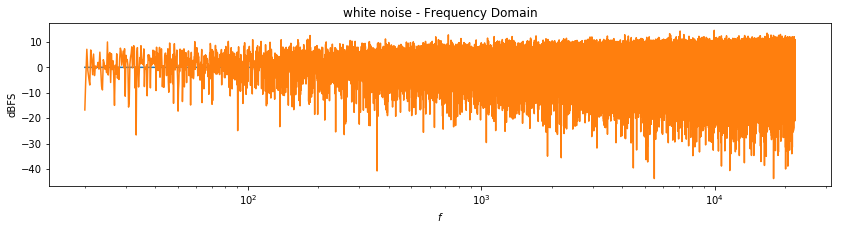

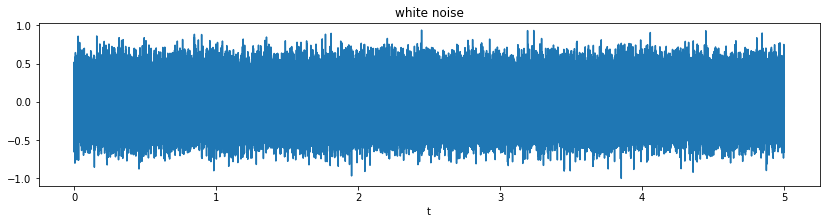

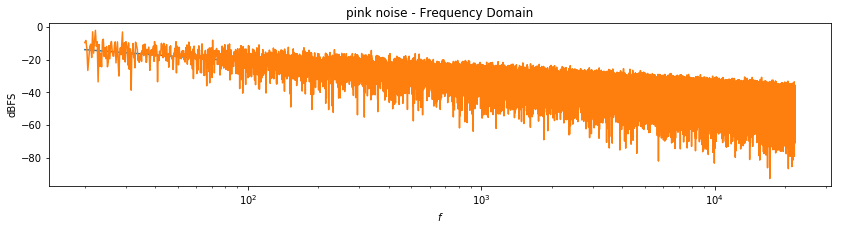

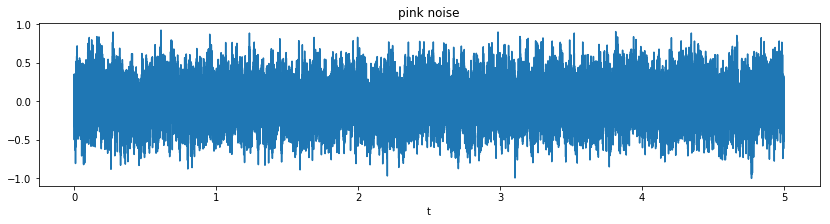

In [206]:
L = 5 # seconds
fs = 44100
t = np.linspace(0, L, int(L*fs)+1)
f = np.linspace(20,fs/2, int(2*L*fs))

white, WHITE = noise_signal(L, fs, dBGain = 0, color="white", export=True, plot=True)
pink, PINK = noise_signal(L, fs, dBGain = 0, color="pink", export=True, plot=True)
red, RED = noise_signal(L, fs, dBGain = 0, color="red", export=True, plot=False)
plt.show()

In [130]:
# fsFile, whiteFile = scipy.io.wavfile.read("recordings/dummy nrr 25.wav")
# tFile = np.linspace(0,len(whiteFile)/fsFile, fsFile*len(whiteFile))
# print whiteFile.shape
# print tFile.shape

# plt.plot(tFile, whiteFile)
# plt.show()

In [131]:
# plt.figure(figsize=(6,4))
# plt.plot(hann, label="Window")
# plt.title("Hann window")
# plt.xlabel("Samples")
# plt.show();

In [132]:
def getWindows(sig, fs, fmin):
    Ny = fs/2
    width = 1/float(fmin) # seconds
    hann = signal.hanning(width*fs, sym=False)
    Lh = len(hann)
    freq = np.linspace(0, Ny, Lh/2+1)
    n_windows = int(2*(L/width) - 1)

    windows = [None]*n_windows
    WINDOWS = [None]*n_windows

    for i in range(0,n_windows):
        a = int(i*width/float(2) * fs) 
        b = int((i*width/float(2) + width) * fs)
        if b - a < len(hann):
            b +=  len(hann) - (b-a)
        windows[i] = sig[a : b] * hann
        WINDOWS[i] = np.fft.rfft(windows[i])
    return windows, WINDOWS

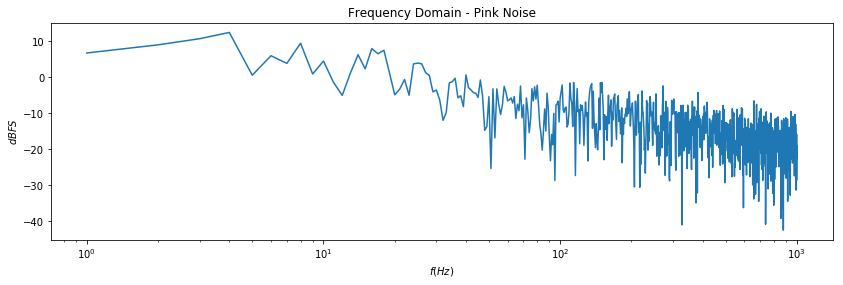

In [133]:
pinkwindows, PINKWINDOWS = getWindows(pink, fs, fmin=22)

plt.figure(figsize=(14,4))
plt.semilogx(db(np.mean(PINKWINDOWS, axis=0)))
plt.title("Frequency Domain - Pink Noise")
plt.xlabel("$f (Hz)$")
plt.ylabel('$dBFS$')
plt.show();

This is technically correct—the best kind of correct. But it doesn't really tell us anythink about the signal, other than that it's noisy

# Octave FIlter

Next we'll make an octave filter bank, configurable to the fraction of octave desired (i.e. for a third-octave bank, use `B=3`) and with a variable range and centre frequency. 

In calculating the NRR, we really only need single-octave filters though.

In [226]:
def OctaveBank(B, ny=None, octaves=None, centerFreq=None, plot=None):
    if not(ny):
        ny = float(20000)
    if (octaves):
        K = range(-octaves/2*B, octaves/2*B)
    else:
        K = range(-4*B, 4*B)  
    
    if (centerFreq):
        f0 = centerFreq
    else: 
        f0 = 1000

    Bank = []
    Fc = [] 
    if plot:
        plt.figure(figsize=(14,4))
    for k in K:
        fc = f0*2**((k)/float(B))
        Fc.append(fc)
        fl = fc/float(2**(1/float(2*B)))
        fu = fc*(2**(1/float(2*B)))
        [b, a] = signal.butter(2, [fl/ny, fu/ny], btype='band')
        Bank.append([b,a])
        
        if plot:
            w, h = scipy.signal.freqz(b,a)
            plt.semilogx(w*ny, db(h))
    if plot:
        plt.xlabel("$f$")
        plt.ylabel("dB")
        plt.title("Octave Filter Bank")
        plt.show()
    return Bank, Fc

def ApplyFilterBank(Bank, x):
    y = [None] * len(Bank)
    P = np.zeros(len(Bank))
    for i, filt in enumerate(Bank):
        y[i] = (signal.filtfilt(filt[0], filt[1], x))
        P[i] = getRMS(y[i])
    return P

def FilterBankSTD(Bank, x):
    y = [None] * len(Bank)
    stdev = np.zeros(len(Bank))
    for i, filt in enumerate(Bank):
        y[i] = (signal.filtfilt(filt[0], filt[1], x))
        stdev[i] = np.std(y[i])
    return stdev

def Plot8ve(P, Fc, title=None, color=None):
    if not(color):
        color = 'b'
    plt.figure(figsize=(14,4))
    plt.title("Octave Bands: " + str(title))
    plt.bar(np.log10(Fc), db(P), width=0.25, edgecolor="k", tick_label=Fc, color=color)
    plt.xlabel("Band Centre Frequency (Hz)")
    plt.ylabel('$dBFS$')
    plt.show();

### Testing the Octave Bank
To show that the Octave filter bank is working, we'll find the octave power spectrum of a white noise signal. The expected result is a linearly decreacing function.

/Users/adam/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:16: RuntimeWarning: divide by zero encountered in log10


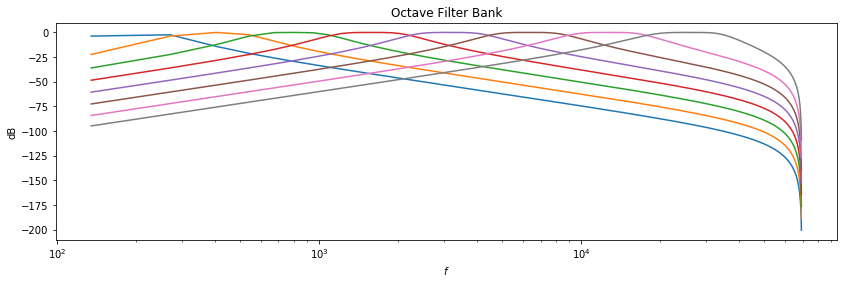

In [227]:
Bank, Fc = OctaveBank(1, ny=Ny, octaves=8, plot=True)    # Create the 1-octave filter bank

The Octave bank looks about right, with some flat tops

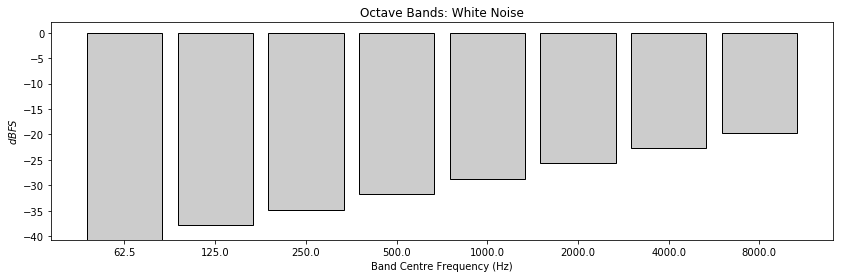

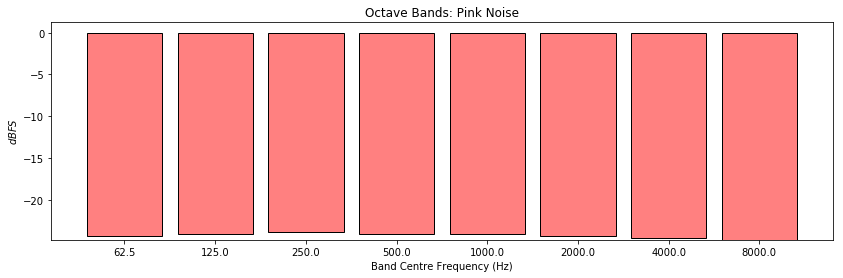

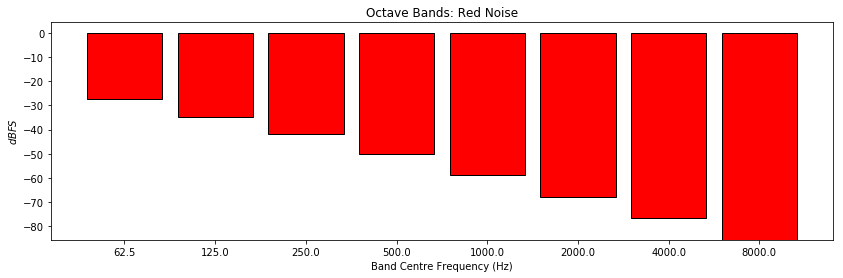

In [228]:
P_white = ApplyFilterBank(Bank, white)
P_pink = ApplyFilterBank(Bank, pink)
P_red = ApplyFilterBank(Bank, red)

Plot8ve(P_white, Fc, title="White Noise", color="#cccccc")
Plot8ve(P_pink, Fc, title="Pink Noise", color="#ff8080")
Plot8ve(P_red, Fc, title="Red Noise", color="r")

Would you look at that! The Octave filters seem to be working fine. Though the Pink noise looks sloped when I believe it should be flat

# Sound Pressure Level (SPL) Weighting

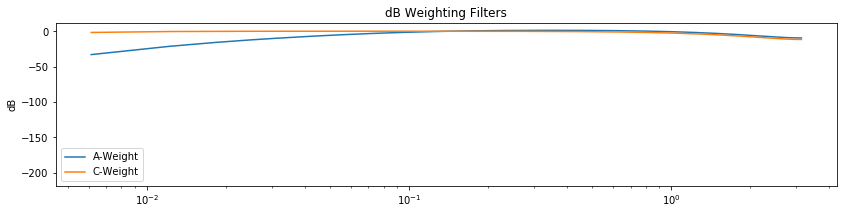

In [192]:
# See https://en.wikipedia.org/wiki/A-weighting
A_poles = [-129.4, -129.4, -676.7, -4636, -76555, -76555];
A_zeros =  [0, 0, 0, 0]
kA = 7.39705E9
C_poles = [-129.4, -129.4, -76655, -76655]
C_zeros =  [0, 0]
kC =  5.91797E9
bA, aA = scipy.signal.zpk2tf(A_zeros, A_poles, kA)
bC, aC = scipy.signal.zpk2tf(C_zeros, C_poles, kC)

sysA = [bA, aA]
sysC = [bC, aC]

baA = scipy.signal.cont2discrete(sysA, 1/float(fs), method="zoh")
baC = scipy.signal.cont2discrete(sysC, 1/float(fs), method="zoh")

wa, ha = scipy.signal.freqz(baA[0][0],baA[1])
wc, hc = scipy.signal.freqz(baC[0][0],baC[1])

plt.figure(figsize=(14,3))
plt.title("dB Weighting Filters")
plt.ylabel("dB")
plt.semilogx(wa, db(ha), label="A-Weight")
plt.semilogx(wc, db(hc), label="C-Weight")
plt.legend(loc="best")
plt.show()

In [136]:
def scale100dB(sig):
    return scipy.signal.lfilter([100],[1], sig)
def AWeight(sig):
    return scipy.signal.lfilter(baA[0][0],baA[1],sig)
def CWeight(sig):
    return scipy.signal.lfilter(baC[0][0],baC[1],sig)

In [238]:
def calcNRR(sig, ref, fs, plot=None):
    # TODO - make sure lengths are equal
    # --
    # TODO - Scale to dBSPL
    # --
    
    Bank, Fc = OctaveBank(1, ny=Ny, octaves=8, plot=False)
    
    # A and C Filter the reference signal
    refA = AWeight(ref)
    refC = CWeight(ref)
    
    # Get the Hann windows for al the signals
    refwindows, RW = getWindows(ref, fs, 1)
    sigwindows, SW = getWindows(sig, fs, 1)
    refAwindows, RWA = getWindows(refA, fs, 1)
    refCwindows, RWC = getWindows(refC, fs, 1)
    
    # Make empty arrays to store the Octave Bands of all the windows
    ref8ve_windows = [None] * len(refwindows)
    sig8ve_windows = [None] * len(sigwindows)
    refA8ve_windows = [None] * len(refAwindows)
    refC8ve_windows = [None] * len(refCwindows)
    Diff_windows = [None] * len(sigwindows)
    
    # Apply Filer Bank to each window
    for i in range(0, len(refwindows)):
        ref8ve_windows[i] = ApplyFilterBank(Bank, refwindows[i])
        sig8ve_windows[i] = ApplyFilterBank(Bank, sigwindows[i])
        refA8ve_windows[i] = ApplyFilterBank(Bank, refAwindows[i])
        refC8ve_windows[i] = ApplyFilterBank(Bank, refCwindows[i])
        # Calculate the difference between the ref and sig
        # added -() since the dB are negative
        Diff_windows[i] = -(db(ref8ve_windows[i]) - db(sig8ve_windows[i]))
        
    # Calculate the average octave band along each window 
    ref8ve = np.mean(ref8ve_windows, axis=0)
    sig8ve = np.mean(sig8ve_windows, axis=0)
    refA8ve = np.mean(refA8ve_windows, axis=0)
    refC8ve = np.mean(refC8ve_windows, axis=0)
    Diff8ve = np.mean(Diff_windows, axis=0)
    
    sig8ve_std = np.std(sig8ve_windows, axis=0)
    Diff8ve_std = np.std(Diff_windows, axis=0)
    
    # The NIOSH Compendium don't care about the 62.5Hz band, so we'll drop that one
#     Fc = Fc[1::]
#     ref8ve = ref8ve[1::]
#     sig8ve = sig8ve[1::]
#     refA8ve = refA8ve[1::]
#     refC8ve = refC8ve[1::]
#     Diff8ve = Diff8ve[1::]
#     sig8ve_std = sig8ve_std[1::]
#     Diff8ve_std = Diff8ve_std[1::]
    
    APV98 = Diff8ve - 2*Diff8ve_std
    Line9 = db(refC8ve) - APV98
    
    NRR = abs(logSum(db(refA8ve)) - logSum(Line9)) - 3
    
    if plot:
        Plot8ve(sig8ve, Fc, title="NRR: " + str(NRR))
    return NRR

In [241]:
pink3dB, PINK3dB = noise_signal(L, fs, dBGain = -3, color="pink")
pink6dB, PINK6dB = noise_signal(L, fs, dBGain = -6, color="pink")
pink10dB, PINK10dB = noise_signal(L, fs, dBGain = -10, color="pink")
pink20dB, PINK20dB = noise_signal(L, fs, dBGain = -20, color="pink")
pink30dB, PINK30dB = noise_signal(L, fs, dBGain = -30, color="pink")

print "-3dB: NRR: " + str(calcNRR(sig=pink3dB, ref=pink, fs=fs))
print "-6dB: NRR: " + str(calcNRR(sig=pink6dB, ref=pink, fs=fs))
print "-10dB: NRR: " + str(calcNRR(sig=pink10dB, ref=pink, fs=fs))
print "-20dB: NRR: " + str(calcNRR(sig=pink20dB, ref=pink, fs=fs))
print "-30dB: NRR: " + str(calcNRR(sig=pink30dB, ref=pink, fs=fs))

-3dB: NRR: 4.08959418032
-6dB: NRR: 6.16649940309
-10dB: NRR: 9.93113105037
-20dB: NRR: 19.7026037227
-30dB: NRR: 30.7073118381
